# 1. Imports

In [1]:
# import sys
# from google.colab import drive

# drive.mount('/content/gdrive', force_remount=True)
# SRC_PATH = '/content/gdrive/MyDrive/MP FEB/FREDDIEMAC'
# DATA_SRC_PATH = SRC_PATH + "/data"
# sys.path.append(SRC_PATH)

# !pip install wandb -qqq
# import wandb
# wandb.login()

# !pip install dask[dataframe] -qqq
# !pip install fastparquet python-snappy -qqq
# import dask.dataframe as dd



# wandb.init(
#     # Set the project where this run will be logged
#     project="baseline_FREDDIEMAC", 
#     # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
#     #name="experiment 1"
#     # Track hyperparameters and run metadata
#     #config={
#       #"learning_rate": 0.02,
#       #"architecture": "CNN",
#       #"dataset": "CIFAR-100",
#       #"epochs": 10,}
#     )

In [2]:
DATA_SRC_PATH = "./data"

In [3]:
%load_ext autoreload
%autoreload 2

import dask.dataframe as dd
import os
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
%matplotlib inline

DEVICE = 'cuda'

# 2. Import Dataset

### 2.1 Loading raw data

In [4]:
blumenstock_types = {'LOAN_SEQUENCE_NUMBER': str, 'INT_RATE': float, 'ORIG_UPB': float, 'FICO_SCORE': float,
                    'DTI_R': float, 'LTV_R': float, 'FIRST_PAYMENT_DATE': str, 'BAL_REPAID': float, 'T_ACT_12M': float, 'T_DEL_30D': float, 
                    'T_DEL_60D': float, 'LABEL': float, 'REMAINING_MONTHS_TO_LEGAL_MATURITY': float, "TIME_TO_EVENT": float, 'TOTAL_OBSERVED_LENGTH': float}

df_blumenstock = dd.read_parquet(DATA_SRC_PATH + "/blumenstock_labeled_sample_orig_*.parquet.gzip", engine="fastparquet")
df_blumenstock = df_blumenstock.astype(blumenstock_types)

### 2.2 Normalising raw data

In [5]:
covariates_to_normalise = ['INT_RATE', 'ORIG_UPB', 'FICO_SCORE', 'DTI_R', 'LTV_R', 'REMAINING_MONTHS_TO_LEGAL_MATURITY',
                           'BAL_REPAID', 'T_ACT_12M', 'T_DEL_30D', 'T_DEL_60D']

df_blumenstoch_mean = df_blumenstock[covariates_to_normalise].mean().compute()
df_blumenstoch_std = df_blumenstock[covariates_to_normalise].std().compute()

df_blumenstock[covariates_to_normalise] = (df_blumenstock[covariates_to_normalise] - df_blumenstoch_mean) / df_blumenstoch_std


### 2.3 Splitting train, validation and test-set

In [6]:
train_df_blumenstock, validate_df_blumenstock, test_df_blumenstock = df_blumenstock.random_split([0.9, 0.08, 0.02])
print("Total train set contains %d samples", len(train_df_blumenstock))
print("Total validation set contains %d samples", len(validate_df_blumenstock))
print("Total test set contains %d samples", len(test_df_blumenstock))
print("-------------------------------------------------------------")

AMOUNT_OF_TRAIN_SAMPLES = 2**12 + 1
AMOUNT_OF_VALIDATE_SAMPLES = 2**8 + 1
AMOUNT_OF_TEST_SAMPLES = 2**7 + 1

total_amount_of_train_samples = len(train_df_blumenstock)
total_amount_of_validate_samples = len(validate_df_blumenstock)
total_amount_of_test_samples = len(test_df_blumenstock)

train_df_blumenstock = train_df_blumenstock.sample(frac=AMOUNT_OF_TRAIN_SAMPLES/total_amount_of_train_samples, replace=None, random_state=2022)
validate_df_blumenstock = validate_df_blumenstock.sample(frac=AMOUNT_OF_VALIDATE_SAMPLES/total_amount_of_validate_samples, replace=None, random_state=2022)
test_df_blumenstock = test_df_blumenstock.sample(frac=AMOUNT_OF_TEST_SAMPLES/total_amount_of_test_samples, replace=None, random_state=2022)

print("Total train set contains %d samples", len(train_df_blumenstock))
print("Total validation set contains %d samples", len(validate_df_blumenstock))
print("Total test set contains %d samples", len(test_df_blumenstock))

Total train set contains %d samples 22082
Total validation set contains %d samples 2048
Total test set contains %d samples 485
-------------------------------------------------------------
Total train set contains %d samples 4097
Total validation set contains %d samples 257
Total test set contains %d samples 129


### 2.4 Creating dataloaders

In [7]:
from torch.utils.data import DataLoader
from FREDDIEMAC_baseline_data import FREDDIEMAC_basline_dataset, FREDDIEMAC_baseline_dataloader

allowed_covariates = ['INT_RATE', 'ORIG_UPB', 'FICO_SCORE', 'DTI_R','LTV_R', 'BAL_REPAID', 
                     'T_ACT_12M', 'T_DEL_30D', 'T_DEL_60D', 'REMAINING_MONTHS_TO_LEGAL_MATURITY']

TIME_TO_EVENT_covariate ='TIME_TO_EVENT'
LABEL_covariate = 'LABEL'
random_state = 123
data_augment_factor = 3

BATCH_SIZE = 2**7
print("BATCH_SIZE = ", BATCH_SIZE)

BATCH_SIZE =  128


#### 2.4.1 Creating train dataloader

In [8]:
train_FREDDIEMAC_raw_dataset = FREDDIEMAC_basline_dataset(train_df_blumenstock, 
                                                          allowed_covariates,
                                                          TIME_TO_EVENT_covariate,
                                                          LABEL_covariate,
                                                          frac_cases=1,
                                                          random_state=random_state,
                                                          test_set=False,
                                                          augment=False,
                                                          data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(train_FREDDIEMAC_raw_dataset))
train_data_loader = FREDDIEMAC_baseline_dataloader(dataset=train_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % train_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(train_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 4097 samples
This dataloader will deliver 32 batches
torch.Size([128, 1, 10])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.2 Creating validate dataloader

In [9]:
validate_FREDDIEMAC_raw_dataset = FREDDIEMAC_basline_dataset(validate_df_blumenstock, 
                                                          allowed_covariates,
                                                          TIME_TO_EVENT_covariate,
                                                          LABEL_covariate,
                                                          frac_cases=1,
                                                          random_state=random_state,
                                                          test_set=False,
                                                          augment=False,
                                                          data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(validate_df_blumenstock))
validate_data_loader = FREDDIEMAC_baseline_dataloader(dataset=validate_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % validate_data_loader.get_max_iterations())
batch_data, batch_data_length, batch_event, batch_tte = next(validate_data_loader)

print(batch_data.shape)
print(batch_data_length.shape)
print(batch_event.shape)
print(batch_tte.shape)

This dataset will contain 257 samples
This dataloader will deliver 2 batches
torch.Size([128, 1, 10])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])


#### 2.4.3 creating a test sample

In [10]:
test_FREDDIEMAC_raw_dataset = FREDDIEMAC_basline_dataset(test_df_blumenstock, 
                                                          allowed_covariates,
                                                          TIME_TO_EVENT_covariate,
                                                          LABEL_covariate,
                                                          frac_cases=1,
                                                          random_state=random_state,
                                                          test_set=False,
                                                          augment=False,
                                                          data_augment_factor=data_augment_factor)

print("This dataset will contain %d samples" % len(test_df_blumenstock))
test_data_loader = FREDDIEMAC_baseline_dataloader(dataset=test_FREDDIEMAC_raw_dataset, batch_size=BATCH_SIZE)
print("This dataloader will deliver %d batches" % test_data_loader.get_max_iterations())
test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(test_data_loader)

print(test_batch_data.shape)
print(test_batch_data_length.shape)
print(test_batch_event.shape)
print(test_batch_tte.shape)

print("The first sample will look like this:")
print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (test_batch_event[0], test_batch_data_length[0], test_batch_tte[0]))

This dataset will contain 129 samples
This dataloader will deliver 1 batches
torch.Size([128, 1, 10])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
The first sample will look like this:
batch event= 0 --- batch_data_length= 21 --- batch_tte= 21


### 2.5 Data Exploration

In [11]:
batch_data, batch_data_length, batch_event, batch_tte = next(iter(train_data_loader))

for i in range(min(BATCH_SIZE, 16)):
    print("batch event= %d --- batch_data_length= %d --- batch_tte= %d" % (batch_event[i], batch_data_length[i], batch_tte[i]))

batch event= 0 --- batch_data_length= 14 --- batch_tte= 14
batch event= 0 --- batch_data_length= 139 --- batch_tte= 139
batch event= 0 --- batch_data_length= 28 --- batch_tte= 28
batch event= 0 --- batch_data_length= 53 --- batch_tte= 53
batch event= 3 --- batch_data_length= 135 --- batch_tte= 135
batch event= 3 --- batch_data_length= 135 --- batch_tte= 135
batch event= 0 --- batch_data_length= 19 --- batch_tte= 19
batch event= 0 --- batch_data_length= 19 --- batch_tte= 19
batch event= 0 --- batch_data_length= 119 --- batch_tte= 119
batch event= 0 --- batch_data_length= 132 --- batch_tte= 132
batch event= 0 --- batch_data_length= 108 --- batch_tte= 108
batch event= 0 --- batch_data_length= 122 --- batch_tte= 122
batch event= 0 --- batch_data_length= 12 --- batch_tte= 12
batch event= 0 --- batch_data_length= 17 --- batch_tte= 17
batch event= 0 --- batch_data_length= 54 --- batch_tte= 54
batch event= 0 --- batch_data_length= 35 --- batch_tte= 35


# 3. Hyperparameters

In [12]:
from torch.nn import MSELoss
from tqdm import trange, tqdm

from torch.optim import Adam

from deepHit import Encoder, CauseSpecificSubnetwork, DeepHit
from baseline_losses import loss_1_batch, loss_2_batch

NUM_EPOCHS = 1

LEARNING_RATE_ENCODER = 1e-3
LEARNING_RATE_CAUSESS = 1e-3

LOSS_1_AMPLIFIER = 1
LOSS_2_AMPLIFIER = 5

RUN_VALIDATION_ROUND = True
RUN_VALIDATION_ROUND_BATCHES_THRESHOLD = 2**2
VAL_NUM_CASES_RUNTIME = BATCH_SIZE

input_size = train_FREDDIEMAC_raw_dataset.get_num_covariates()
output_size = train_FREDDIEMAC_raw_dataset.get_num_covariates()
MAX_LENGTH = train_FREDDIEMAC_raw_dataset.get_max_length()

NUM_CAUSES = 3
hidden_size_encoder = 300
context_size = 300
hidden_cause_size = 50*NUM_CAUSES
SIGMA = 0.1

# 4. Defining The Model

In [13]:
# initialize model
encoder = Encoder(input_size, hidden_size_encoder, context_size).to(DEVICE)
causess = CauseSpecificSubnetwork(context_size, hidden_cause_size, input_size, MAX_LENGTH, NUM_CAUSES).to(DEVICE)
DHT = DeepHit(encoder, causess, DEVICE)

# intialize optimizer
optimizer_encoder = Adam(encoder.parameters(), lr=LEARNING_RATE_ENCODER, weight_decay=1)
optimizer_causess = Adam(causess.parameters(), lr=LEARNING_RATE_CAUSESS, weight_decay=1)

### 4.1 Testing a sample before training

For the first sample of the test batch:
sample has length 21
the model predicts the event 0 at time 156
probability of prepay event = 0.33
probability of default event = 0.33
probability of full repay event = 0.33


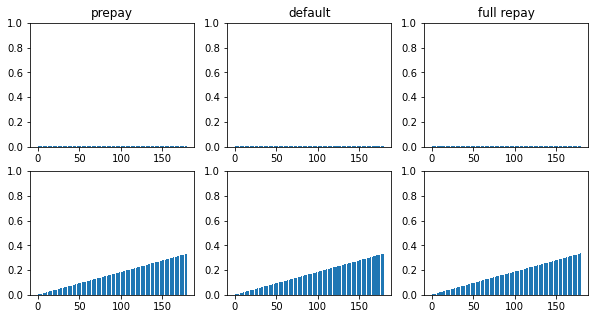

In [14]:
from utils import plot_fht_and_cif_baseline
from baseline_losses import CIF_K

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DHT.eval()

test_first_hitting_time = DHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("For the first sample of the test batch:")
print("sample has length %d" % test_batch_data_length[0])
print("the model predicts the event %d at time %d" % (model_event_prediction[0], model_tte_prediction[0] + 1))

print("probability of prepay event = %.2f" % CIF_K(test_first_hitting_time[0], 0, MAX_LENGTH)[-1].item())
print("probability of default event = %.2f" % CIF_K(test_first_hitting_time[0], 1, MAX_LENGTH)[-1].item())
print("probability of full repay event = %.2f" % CIF_K(test_first_hitting_time[0], 2, MAX_LENGTH)[-1].item())

plot_fht_and_cif_baseline(test_first_hitting_time[0], MAX_LENGTH)

# 5. Training the model

In [15]:
#PATH = "/content/gdrive/MyDrive/MP FEB/FREDDIEMAC/models/baseline_model_v5.pth"

# start training
for epoch in range(NUM_EPOCHS):
  
  epoch_loss = 0
  train_epoch_val_loss = 0
  train_epoch_val_loss1 = 0
  train_epoch_val_loss2 = 0

  for batch_number in range(len(train_data_loader)):
    data = next(train_data_loader)

    batch_loss = 0

    optimizer_encoder.zero_grad()
    optimizer_causess.zero_grad()

    batch_data, batch_data_length, batch_event, batch_tte = data
    batch_data = batch_data.to(DEVICE)
    batch_data_length = batch_data_length.to(DEVICE)
    batch_event = batch_event.to(DEVICE)
    batch_tte = batch_tte.to(DEVICE)
    
    first_hitting_time_batch = DHT(batch_data, batch_data_length)

    loss1 = LOSS_1_AMPLIFIER*loss_1_batch(first_hitting_time_batch, batch_event, batch_tte, MAX_LENGTH, DEVICE)
    loss2 = LOSS_2_AMPLIFIER*loss_2_batch(first_hitting_time_batch, batch_event, batch_tte, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)

    batch_loss = loss1 + loss2
    batch_loss.backward()

    epoch_loss += batch_loss.detach()

    #wandb.log({"train_loss1": loss1.item(), "train_loss2": loss2.item()})
    print({"train_loss1": loss1.item(), "train_loss2": loss2.item()})

    optimizer_encoder.step()
    optimizer_causess.step()

    if RUN_VALIDATION_ROUND and batch_number % 2**4 == 0:
      # validating round
      #torch.save(DHT.state_dict(), PATH)
      DHT.eval()

      val_epoch_val_loss = 0
      val_epoch_val_loss1 = 0
      val_epoch_val_loss2 = 0

      for validation_batch_number in range(len(validate_data_loader)):
        data = next(validate_data_loader)

        with torch.no_grad():
          val_batch_data, val_data_length, val_batch_event, val_batch_tte  = data
          val_batch_data = val_batch_data.to(DEVICE)
          val_data_length = val_data_length.to(DEVICE)
          val_batch_event = val_batch_event.to(DEVICE)
          val_batch_tte = val_batch_tte.to(DEVICE)

          val_first_hitting_time_batch = DHT(val_batch_data, val_data_length)

          val_loss1 = LOSS_1_AMPLIFIER*loss_1_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, MAX_LENGTH, DEVICE)/VAL_NUM_CASES_RUNTIME
          val_loss2 = LOSS_2_AMPLIFIER*loss_2_batch(val_first_hitting_time_batch, val_batch_event, val_batch_tte, NUM_CAUSES, MAX_LENGTH, SIGMA, DEVICE)/VAL_NUM_CASES_RUNTIME
          
          val_epoch_val_loss1 += val_loss1
          val_epoch_val_loss2 += val_loss2
          val_epoch_val_loss = val_loss1 + val_loss2

      #wandb.log({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item(), "val_epoch_val_loss": val_epoch_val_loss.item()})
      print({"val_epoch_val_loss1": val_epoch_val_loss1.item(), "val_epoch_val_loss2": val_epoch_val_loss2.item()})

      DHT.train()
      # end validating round

  #wandb.log({"train_epoch_loss" : epoch_loss.item()})
  #torch.save(DHT.state_dict(), PATH)

#wandb.finish() 

{'train_loss1': 737.9148559570312, 'train_loss2': 310.6332092285156}
{'val_epoch_val_loss1': 11.132501602172852, 'val_epoch_val_loss2': 4.786618709564209}
{'train_loss1': 736.142822265625, 'train_loss2': 311.85467529296875}
{'train_loss1': 733.6510009765625, 'train_loss2': 310.6064453125}
{'train_loss1': 738.6975708007812, 'train_loss2': 309.1357727050781}
{'train_loss1': 735.2045288085938, 'train_loss2': 308.7223815917969}
{'train_loss1': 729.917724609375, 'train_loss2': 308.0206298828125}
{'train_loss1': 731.896240234375, 'train_loss2': 309.1625671386719}
{'train_loss1': 724.7975463867188, 'train_loss2': 308.4648742675781}
{'train_loss1': 726.4429321289062, 'train_loss2': 306.0483703613281}
{'train_loss1': 720.6385498046875, 'train_loss2': 306.335205078125}
{'train_loss1': 716.7630615234375, 'train_loss2': 308.0310363769531}
{'train_loss1': 719.6262817382812, 'train_loss2': 305.8831481933594}
{'train_loss1': 709.752685546875, 'train_loss2': 304.10650634765625}
{'train_loss1': 703.327

# 6. Testing the model

In [16]:
#PATH = "/content/gdrive/MyDrive/MP FEB/FREDDIEMAC/models/baseline_model_v5.pth"
#DHT.load_state_dict(torch.load(PATH))

### 6.1 Testing a sample after training

For the first sample of the test batch:
sample has length 21 and will experience event 0
the model predicts at time 28 the event 0 
probability of prepay event = 0.58
probability of default event = 0.21
probability of full repay event = 0.21


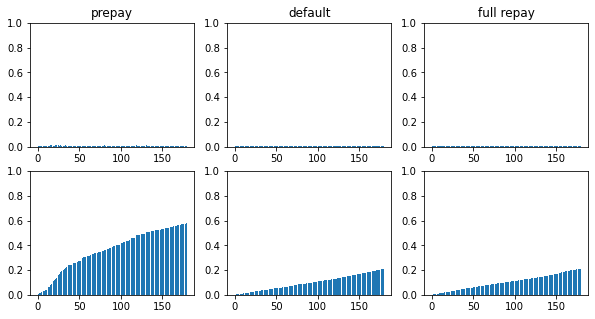

In [17]:
from utils import plot_fht_and_cif_baseline
from baseline_losses import CIF_K

test_sample_index = 0

test_batch_data, test_batch_data_length, test_batch_event, test_batch_tte = next(iter(test_data_loader))

test_batch_data = test_batch_data.to(DEVICE)
test_batch_data_length = test_batch_data_length.to(DEVICE)
test_batch_event = test_batch_event.to(DEVICE)

DHT.eval()

test_first_hitting_time = DHT(test_batch_data, test_batch_data_length)
test_first_hitting_time_argmax = test_first_hitting_time.argmax(dim=1)
model_event_prediction = test_first_hitting_time_argmax // MAX_LENGTH
model_tte_prediction = test_first_hitting_time_argmax % MAX_LENGTH

print("For the first sample of the test batch:")
print("sample has length %d and will experience event %d" % (test_batch_data_length[test_sample_index], test_batch_event[test_sample_index]))
print("the model predicts at time %d the event %d " % (model_tte_prediction[test_sample_index] + 1, model_event_prediction[test_sample_index]))

print("probability of prepay event = %.2f" % CIF_K(test_first_hitting_time[test_sample_index], 0, MAX_LENGTH)[-1].item())
print("probability of default event = %.2f" % CIF_K(test_first_hitting_time[test_sample_index], 1, MAX_LENGTH)[-1].item())
print("probability of full repay event = %.2f" % CIF_K(test_first_hitting_time[test_sample_index], 2, MAX_LENGTH)[-1].item())

plot_fht_and_cif_baseline(test_first_hitting_time[test_sample_index], MAX_LENGTH)

In [18]:
for test_sample_index in range(2**3):
  print("sample will experiece event: %d - at time %d" % (test_batch_event[test_sample_index], test_batch_data_length[test_sample_index]))
  print("model will predict event:    %d - at time %d" % (model_event_prediction[test_sample_index], model_tte_prediction[test_sample_index]))

  print("--------------------------------------------")



sample will experiece event: 0 - at time 21
model will predict event:    0 - at time 27
--------------------------------------------
sample will experiece event: 3 - at time 137
model will predict event:    0 - at time 118
--------------------------------------------
sample will experiece event: 0 - at time 101
model will predict event:    0 - at time 131
--------------------------------------------
sample will experiece event: 3 - at time 132
model will predict event:    0 - at time 131
--------------------------------------------
sample will experiece event: 0 - at time 132
model will predict event:    0 - at time 118
--------------------------------------------
sample will experiece event: 3 - at time 142
model will predict event:    0 - at time 118
--------------------------------------------
sample will experiece event: 0 - at time 28
model will predict event:    0 - at time 27
--------------------------------------------
sample will experiece event: 0 - at time 101
model will pre

[1. 0. 0.]


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (4).

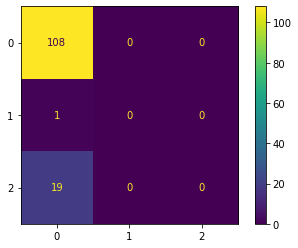

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

a = test_batch_event.flatten().cpu()
b = model_event_prediction.cpu()

cm = confusion_matrix(a, b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1', '2', '3'])
accuracy = cm.diagonal()/cm.sum(axis=1)

print(accuracy)

disp.plot()
plt.show()

